## Part III. SVM Logit


### Importing Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from pylab import rcParams
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from conf_matrix import func_confusion_matrix

ModuleNotFoundError: ignored

### Functions for Model Evaluation

In [ ]:
def generate_model_report(y_actual, y_predicted):
    print("Accuracy: " , accuracy_score(y_actual, y_predicted))
    print("Precision:" ,precision_score(y_actual, y_predicted))
    print("Recall:   " ,recall_score(y_actual, y_predicted))
    print("F1 Score: " ,f1_score(y_actual, y_predicted))
    print("AUC Score:" , roc_auc_score(y_actual, y_predicted))
    pass

In [ ]:
def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  y_pred_proba)
    auc = roc_auc_score(Y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="ROC Curve with AUC ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

### Importing and Cleaning Data

In [ ]:
sdata = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [ ]:
sdata.shape

(5110, 12)

In [ ]:
sdata = sdata[sdata.gender != 'Other']
sdata['gender'] = sdata['gender'].replace({'Male':0,'Female':1}).astype(np.uint8)
sdata['ever_married'] =sdata['ever_married'].replace({'No':0,'Yes':1}).astype(np.uint8)
sdata['Residence_type'] =sdata['Residence_type'].replace({'Rural':0,'Urban':1}).astype(np.uint8)

In [ ]:
one_hot = pd.get_dummies(sdata['work_type'])
sdata = sdata.drop('work_type',axis = 1)
sdata = sdata.join(one_hot)
one_hot = pd.get_dummies(sdata['smoking_status'])
sdata = sdata.drop('smoking_status',axis = 1)
sdata = sdata.join(one_hot)

In [ ]:
from sklearn.impute import KNNImputer
# there are 201 missing values in the BMI column, 40 of which epxerienced a stroke event, 
# so we impute using kNN:
imputer = KNNImputer(n_neighbors=70)
sdatakNN = imputer.fit_transform(sdata)
sdata = pd.DataFrame(sdatakNN, columns=sdata.columns)


#sdata = sdata.dropna()

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Splitting Data

In [ ]:
X, Y = (sdata.drop(columns=['id','stroke']),sdata['stroke'])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X = MinMaxScaler().fit_transform(X) #turn off and on depending on if we want normalized or un-normalized data

#Splitting data into train, validation, test 

print("Features data shape: {}".format(X.shape))
print("Target data shape: {}".format(Y.shape))

#Test train split for train vs test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5,random_state=425)

#Test train split for train vs validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2,random_state=425)

Features data shape: (5109, 17)
Target data shape: (5109,)


# SVM

## Baseline- SVM 

In [ ]:
#Importing necessary packages 
import sklearn.svm as svm
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
## Baseline SVM
svm_base = svm.SVC(random_state=425).fit(X_train, Y_train)
#predicting the model using the test data 
svm_base_predict = svm_base.predict(X_test)
#generating the model report
generate_model_report(Y_test, svm_base_predict)
#creating the matrix for actual vs predicted
pd.crosstab(svm_base_predict, Y_test, rownames=['Predicted'], colnames=['Actual'])

Accuracy:  0.950293542074364
Precision: 0.0
Recall:    0.0
F1 Score:  0.0
AUC Score: 0.5


Actual,0.0,1.0
Predicted,,
0.0,2428,127


In [ ]:

#predicting the svm base model and printing it 
svm_base_predict = pd.Series(svm_base_predict)
svm_base_predict

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2550    0.0
2551    0.0
2552    0.0
2553    0.0
2554    0.0
Length: 2555, dtype: float64

## Over Sampling- SVM

In [ ]:
from imblearn.over_sampling import SMOTE

## Initialize dataframe of all parameters to be validated
results = pd.DataFrame(columns = ['Weight', 
                                  'Kernel', 
                                  'C Value',  
                                  'Accuracy', 
                                  'F1 Score', 
                                  'AUC Score'])

## Loop over all parameters
for weight in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]: # SMOTE Ratio
    for k in ['linear', 'poly','rbf']:
        for c in np.linspace(0.01, 10, 100):
            
            
            ## Oversampling technique
            sm = SMOTE(random_state=425, sampling_strategy=weight)
            X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)
                        
            ## Model definition
            model = svm.SVC(kernel=k, 
                            C=c, 
                            random_state=425)
                        
            ## Model fitting
            SVM = model.fit(X_train_res, Y_train_res)
            Y_val_pred = model.predict(X_val) # predicted values
                        
            ## Model evaluation
            accuracy = accuracy_score(Y_val, Y_val_pred)
            f1 = f1_score(Y_val, Y_val_pred)
            auc = roc_auc_score(Y_val, Y_val_pred)
                        
            ## Append results to dataframe
            results = results.append({'Weight':weight, 
                                        'Kernel':k,
                                        'C Value': c,
                                        'Accuracy':accuracy,
                                        'F1 Score':f1,
                                        'AUC Score': auc}, ignore_index = True)

In [ ]:
## Retrieve result with highest F1 Score 
results.loc[results['F1 Score'].idxmax()]

Weight       0.500000
Kernel           poly
C Value      0.817273
Accuracy     0.908023
F1 Score     0.318841
AUC Score    0.686049
Name: 1308, dtype: object

In [ ]:
## Another loop to get more granularity of SMOTE
# Before I tested 10 different smote weights, now I test 3000
results_sm = pd.DataFrame(columns = ['Weight', 'Accuracy', 'F1 Score', 'MA_Acc', 'MA_F1'])
weights = np.linspace(0.1, 1, 3000)

for weight in weights:
    sm = SMOTE(random_state=425, sampling_strategy=weight)
    X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)
    model = svm.SVC(kernel='poly', 
                    C= 0.817273, 
                    random_state=425).fit(X_train_res, Y_train_res)
    Y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(Y_val, Y_val_pred)
    f1 = f1_score(Y_val, Y_val_pred)
    results_sm = results_sm.append({'Weight':weight, 'Accuracy':accuracy,'F1 Score':f1}, ignore_index = True)

Text(0, 0.5, 'F1 Score')

Text(0.5, 0, 'SMOTE Weight')

Text(0, 0.5, 'Accuracy')

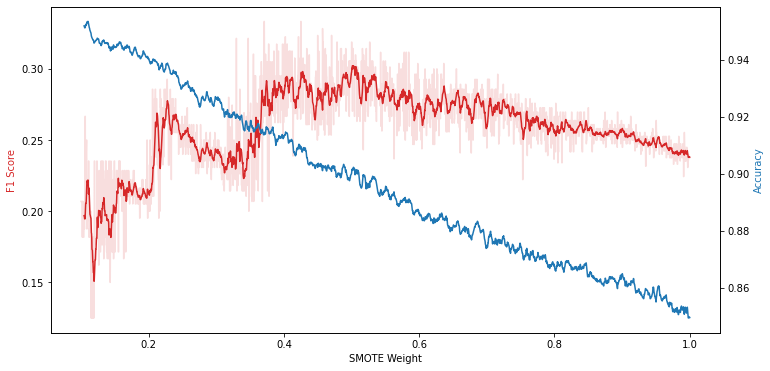

In [ ]:
## Plotting moving average of SMOTE weights and scors
for i in range(15,len(results)):
    results_sm['MA_F1'][i] = (results_sm['F1 Score'][i-15:i]).mean()
    results_sm['MA_Acc'][i] = (results_sm['Accuracy'][i-15:i]).mean()

## Plot
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(results_sm['Weight'], results_sm['MA_F1'], color='tab:red', label="F1 Score")
ax.plot(results_sm['Weight'], results_sm['F1 Score'], color='tab:red', label="F1 Score", alpha=0.15)
ax.set_ylabel('F1 Score', color='tab:red')
ax.set_xlabel("SMOTE Weight")
ax2=ax.twinx()
ax2.plot(results_sm['Weight'], results_sm['MA_Acc'], color='tab:blue', label="Accuracy")
ax2.set_ylabel('Accuracy', color='tab:blue')
plt.show()

In [ ]:
## Retrieve result with highest F1 Score
results_sm.loc[results_sm['F1 Score'].idxmax()]

Weight      0.425008
Accuracy    0.913894
F1 Score    0.333333
MA_Acc      0.909589
MA_F1       0.292487
Name: 1083, dtype: float64

In [ ]:
## Run best model on testing data, only trying to optimize weight, keep the kernal and C parameter from before 
sm = SMOTE(random_state=425, sampling_strategy=0.425008)
X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)
model = svm.SVC(kernel='poly', 
                    C= 0.817273, 
                    random_state=425).fit(X_train_res, Y_train_res)
#testing the best model on the test data
Y_test_pred = model.predict(X_test)
#generating the model report
generate_model_report(Y_test, Y_test_pred)
#creating the confusion matrix 
conf_mat = confusion_matrix(Y_test, Y_test_pred)
pd.crosstab(Y_test, Y_test_pred, rownames=['Predicted'], colnames=['Actual'])

Accuracy:  0.8700587084148728
Precision: 0.11895910780669144
Recall:    0.25196850393700787
F1 Score:  0.1616161616161616
AUC Score: 0.5771786506505467


Actual,0.0,1.0
Predicted,,
0.0,2191,237
1.0,95,32


## Under Sampling- SVM

In [ ]:
from imblearn.under_sampling import NearMiss

## Initialize dataframe of all parameters to be validated
results = pd.DataFrame(columns = ['Neighbor', 
                                  'Kernel', 
                                  'C Value',  
                                  'Accuracy', 
                                  'F1 Score', 
                                  'AUC Score'])

## Loop over all parameters
for neighbor in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    for k in ['linear', 'poly','rbf']:
        for c in np.linspace(0.01, 10, 100):
                        
            ## Underampling technique
            nm = NearMiss(version=1,n_neighbors=neighbor)
            X_train_res, Y_train_res = nm.fit_resample(X_train, Y_train)
                        
            ## Model definition
            model = svm.SVC(kernel=k, 
                            C=c, 
                            random_state=425)
                        
            ## Model fitting
            SVM = model.fit(X_train_res, Y_train_res)
            Y_val_pred = model.predict(X_val) # predicted values
                        
            ## Model evaluation
            accuracy = accuracy_score(Y_val, Y_val_pred)
            f1 = f1_score(Y_val, Y_val_pred)
            auc = roc_auc_score(Y_val, Y_val_pred)
                        
            ## Append results to dataframe
            results = results.append({'Neighbor':neighbor, 
                                      'Kernel':k,
                                      'C Value': c,
                                      'Accuracy':accuracy,
                                      'F1 Score':f1,
                                      'AUC Score': auc}, ignore_index = True)

In [ ]:
## Retrieve result with highest F1 Score
results.loc[results['F1 Score'].idxmax()]           

Neighbor            1
Kernel         linear
C Value      3.239091
Accuracy     0.716243
F1 Score     0.224599
AUC Score    0.774938
Name: 32, dtype: object

In [ ]:
## Another loop to get more granularity of SMOTE
# Before I tested 10 different neighbor, now I test 3000
results_sm = pd.DataFrame(columns = ['Neighbor', 'Accuracy', 'F1 Score', 'MA_Acc', 'MA_F1'])
neighbors = np.linspace(0.05, 1, 3000)

for neighbor in neighbors:
    sm = NearMiss(version=1,sampling_strategy=neighbor) 
    X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)
    model = svm.SVC(kernel='linear', 
                    C= 3.239091, 
                    random_state=425).fit(X_train_res, Y_train_res)
    Y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(Y_val, Y_val_pred)
    f1 = f1_score(Y_val, Y_val_pred)
    results_sm = results_sm.append({'Neighbor':neighbor, 'Accuracy':accuracy,'F1 Score':f1}, ignore_index = True)

Text(0, 0.5, 'F1 Score')

Text(0.5, 0, 'NearMiss Neighbor')

Text(0, 0.5, 'Accuracy')

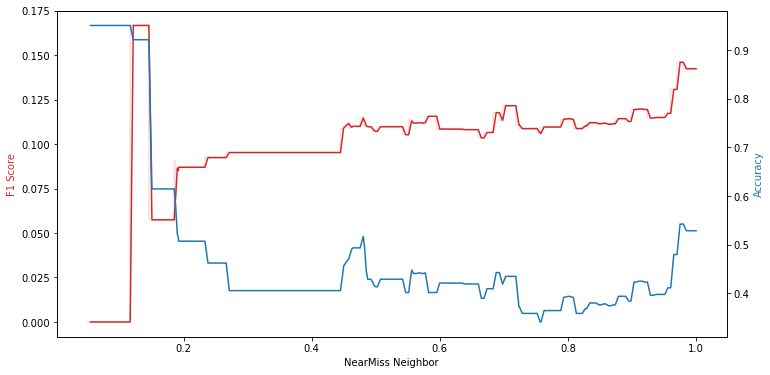

In [ ]:
## Plotting moving average of Best near miss model neighbor and scores
for i in range(15,len(results)):
    results_sm['MA_F1'][i] = (results_sm['F1 Score'][i-15:i]).mean()
    results_sm['MA_Acc'][i] = (results_sm['Accuracy'][i-15:i]).mean()

## Plot
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(results_sm['Neighbor'], results_sm['MA_F1'], color='tab:red', label="F1 Score")
ax.plot(results_sm['Neighbor'], results_sm['F1 Score'], color='tab:red', label="F1 Score", alpha=0.15)
ax.set_ylabel('F1 Score', color='tab:red')
ax.set_xlabel("NearMiss Neighbor")
ax2=ax.twinx()
ax2.plot(results_sm['Neighbor'], results_sm['MA_Acc'], color='tab:blue', label="Accuracy")
ax2.set_ylabel('Accuracy', color='tab:blue')
plt.show()

In [ ]:
## Retrieve result with highest F1 Score
results_sm.loc[results_sm['F1 Score'].idxmax()]

Neighbor    0.116839
Accuracy    0.921722
F1 Score    0.166667
MA_Acc      0.951076
MA_F1       0.000000
Name: 211, dtype: float64

In [ ]:
## Run best model on testing data, only trying to optimize neighbor, keep the kernal and C parameter from before 
sm = NearMiss(version=1, sampling_strategy=0.116839)
X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)
model = svm.SVC(kernel='linear', 
                    C= 3.239091, 
                    random_state=425).fit(X_train_res, Y_train_res)
#using the best model on the test data
Y_test_pred = model.predict(X_test)
#generate the model report
generate_model_report(Y_test, Y_test_pred)
#creating the confusion matrix 
conf_mat = confusion_matrix(Y_test, Y_test_pred)
pd.crosstab(Y_test, Y_test_pred, rownames=['Predicted'], colnames=['Actual'])

Accuracy:  0.9189823874755382
Precision: 0.1875
Recall:    0.1889763779527559
F1 Score:  0.18823529411764706
AUC Score: 0.5730713850225064


Actual,0.0,1.0
Predicted,,
0.0,2324,104
1.0,103,24


## Logit

In [ ]:
#Import necessary packages 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns

## Logit- Base

LogisticRegression()

Accuracy:  0.950293542074364
[[2428    0]
 [ 127    0]]


<AxesSubplot:>

Text(0.5, 15.0, 'Predicted Value')

Text(91.68, 0.5, 'True Value')

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      2428
         1.0       0.00      0.00      0.00       127

    accuracy                           0.95      2555
   macro avg       0.48      0.50      0.49      2555
weighted avg       0.90      0.95      0.93      2555



0.5

Accuracy:  0.950293542074364
Precision: 0.0
Recall:    0.0
F1 Score:  0.0
AUC Score: 0.5


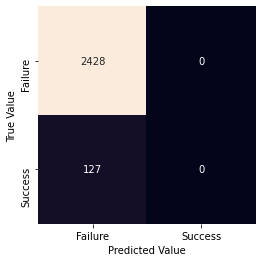

In [ ]:
#Fitting the model 
lr= LogisticRegression()
lr.fit(X_train,Y_train)

#Predicting
Y_Test_Pred1=lr.predict(X_test)
print('Accuracy: ',metrics.accuracy_score(Y_test, Y_Test_Pred1))

#CF
import sklearn.metrics as sklmetrics
conf_mat = sklmetrics.confusion_matrix(Y_test, Y_Test_Pred1)
print(conf_mat)

# Confusion matrix
sns.heatmap(conf_mat, fmt='d',square=True, annot=True, cbar = False, xticklabels = ['Failure','Success'], 
                                                            yticklabels = ['Failure','Success'])
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

#Metrics
print(metrics.classification_report(Y_test,Y_Test_Pred1))

auc = roc_auc_score(Y_test,Y_Test_Pred1)
auc

#generate the model report
generate_model_report(Y_test, Y_Test_Pred1)

## Logit- Over Sampling

In [ ]:
from imblearn.over_sampling import SMOTE

## Initialize dataframe of all parameters to be validated
results = pd.DataFrame(columns = ['Weight', 
                                  'C',  
                                  'Solver',
                                  'Accuracy', 
                                  'F1 Score', 
                                  'AUC Score'])

## Loop over all parameters
for weight in np.linspace(0.1,1,100): # SMOTE Ratio
    for s in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
        for c in range(1,10):
            
                ## Oversampling technique
                sm = SMOTE(random_state=425, sampling_strategy=weight)
                X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)
                        
                ## Model definition
                model = LogisticRegression( 
                                           C=c,
                                            solver=s,
                                           random_state=425)
                        
                ## Model fitting
                lr = model.fit(X_train_res, Y_train_res)
                Y_val_pred = model.predict(X_val) # predicted values
                        
                ## Model evaluation
                accuracy = accuracy_score(Y_val, Y_val_pred)
                f1 = f1_score(Y_val, Y_val_pred)
                auc = roc_auc_score(Y_val, Y_val_pred)
                        
                ## Append results to dataframe
                results = results.append({'Weight':weight, 
                                          'C': c,
                                          'Solver':s,
                                          'Accuracy':accuracy,
                                          'F1 Score':f1,
                                          'AUC Score': auc}, ignore_index = True)

In [ ]:
## Retrieve result with highest F1 Score 
results.loc[results['F1 Score'].idxmax()]

Weight        0.345455
C                    1
Solver       liblinear
Accuracy      0.902153
F1 Score      0.342105
AUC Score     0.720905
Name: 1233, dtype: object

In [ ]:
## Another loop to get more granularity of SMOTE
# Before I tested 10 different smote weights, now I test 3000
results_sm = pd.DataFrame(columns = ['Weight',"C","Solver", 'Accuracy', 'F1 Score', 'MA_Acc', 'MA_F1'])
weights = np.linspace(0.07, 1, 3000)

for weight in weights:
    sm = SMOTE(random_state=425, sampling_strategy=weight)
    X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)
    model = LogisticRegression(C=1,
                               solver="liblinear",
                    random_state=425).fit(X_train_res, Y_train_res)
    Y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(Y_val, Y_val_pred)
    f1 = f1_score(Y_val, Y_val_pred)
    results_sm = results_sm.append({'Weight':weight,"C":c,"Solver":s, 'Accuracy':accuracy,'F1 Score':f1}, ignore_index = True)

Text(0, 0.5, 'F1 Score')

Text(0.5, 0, 'SMOTE Weight')

Text(0, 0.5, 'Accuracy')

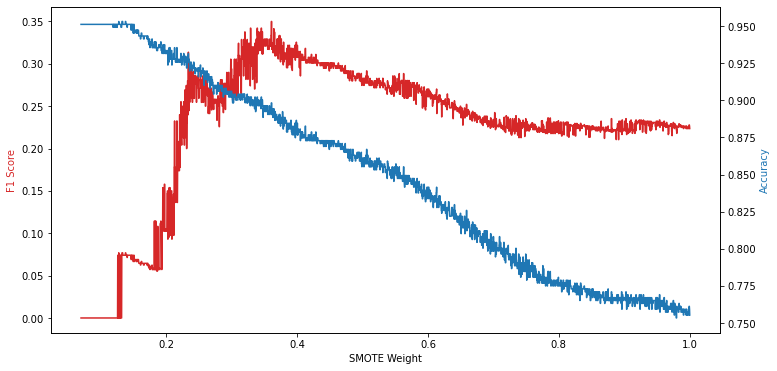

In [ ]:
## Plotting moving average of SMOTE weights and scors
for i in range(15,len(results)):
    results_sm['MA_F1'][i] = (results_sm['F1 Score'][i-15:i]).mean()
    results_sm['MA_Acc'][i] = (results_sm['Accuracy'][i-15:i]).mean()

## Plot
fig, ax = plt.subplots(figsize=(12,6))

#ax.plot(results_sm['Weight'], results_sm['MA_F1'], color='tab:red', label="F1 Score")
ax.plot(results_sm['Weight'], results_sm['F1 Score'], color='tab:red', label="F1 Score", alpha=1)
ax.set_ylabel('F1 Score', color='tab:red')
ax.set_xlabel("SMOTE Weight")
ax2=ax.twinx()
ax2.plot(results_sm['Weight'], results_sm['Accuracy'], color='tab:blue', label="Accuracy")
ax2.set_ylabel('Accuracy', color='tab:blue')
plt.show()

In [ ]:
## Retrieve result with highest F1 Score 
results_sm.loc[results_sm['F1 Score'].idxmax()]

Weight      0.360877
C                  9
Solver          saga
Accuracy    0.898239
F1 Score    0.350000
MA_Acc      0.892629
MA_F1       0.323730
Name: 938, dtype: object

In [ ]:
## Run best model on testing data
sm = SMOTE(random_state=425, sampling_strategy= 0.360877)
X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)
model = LogisticRegression(C=1, 
                           solver='liblinear',
                    random_state=425).fit(X_train_res, Y_train_res)
#using the model on test data
Y_test_pred = model.predict(X_test)
#generate the model report
generate_model_report(Y_test, Y_test_pred)
#confusion matrix 
conf_mat = confusion_matrix(Y_test, Y_test_pred)
pd.crosstab(Y_test, Y_test_pred, rownames=['Predicted'], colnames=['Actual'])

Accuracy:  0.860665362035225
Precision: 0.18282548476454294
Recall:    0.5196850393700787
F1 Score:  0.2704918032786885
AUC Score: 0.6990929315466539


Actual,0.0,1.0
Predicted,,
0.0,2133,295
1.0,61,66


## Logit- Under Sampling

In [ ]:
from imblearn.under_sampling import NearMiss

## Initialize dataframe of all parameters to be validated
results = pd.DataFrame(columns = ['Neighbor', 
                                  'C',  
                                  'Solver',
                                  'Accuracy', 
                                  'F1 Score', 
                                  'AUC Score'])

## Loop over all parameters
for neighbor in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    for s in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
        for c in range(1,10):
                        
            ## Underampling technique
            nm = NearMiss(version=1,n_neighbors=neighbor)
            X_train_res, Y_train_res = nm.fit_resample(X_train, Y_train)
                        
            ## Model definition
            model = LogisticRegression( 
                                           C=c,
                                            solver=s,
                                           random_state=425)
                        
            ## Model fitting
            lr = model.fit(X_train_res, Y_train_res)
            Y_val_pred = model.predict(X_val) # predicted values
                        
            ## Model evaluation
            accuracy = accuracy_score(Y_val, Y_val_pred)
            f1 = f1_score(Y_val, Y_val_pred)
            auc = roc_auc_score(Y_val, Y_val_pred)
                        
            ## Append results to dataframe
            results = results.append({'Neighbor':neighbor, 
                                          'C': c,
                                          'Solver':s,
                                          'Accuracy':accuracy,
                                          'F1 Score':f1,
                                          'AUC Score': auc}, ignore_index = True)

In [ ]:
## Retrieve result with highest F1 Score
results.loc[results['F1 Score'].idxmax()]       

Neighbor             1
C                    9
Solver       newton-cg
Accuracy      0.755382
F1 Score      0.193548
AUC Score     0.681687
Name: 8, dtype: object

In [ ]:
## Another loop to get more granularity of SMOTE
# Before I tested 10 different Neighbors, now I test 3000
results_sm = pd.DataFrame(columns = ['Neighbor',"C","Solver", 'Accuracy', 'F1 Score', 'MA_Acc', 'MA_F1'])
neighbors = np.linspace(0.07, 1, 3000)

for neighbor in neighbors:
    sm = NearMiss(sampling_strategy=neighbor) 
    X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)
    model = LogisticRegression(C=9,
                               solver="newton-cg",
                    random_state=425).fit(X_train_res, Y_train_res)
    Y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(Y_val, Y_val_pred)
    f1 = f1_score(Y_val, Y_val_pred)
    results_sm = results_sm.append({'Neighbor':neighbor,"C":c,"Solver":s, 'Accuracy':accuracy,'F1 Score':f1}, ignore_index = True)

Text(0, 0.5, 'F1 Score')

Text(0.5, 0, 'NearMiss Neighbor')

Text(0, 0.5, 'Accuracy')

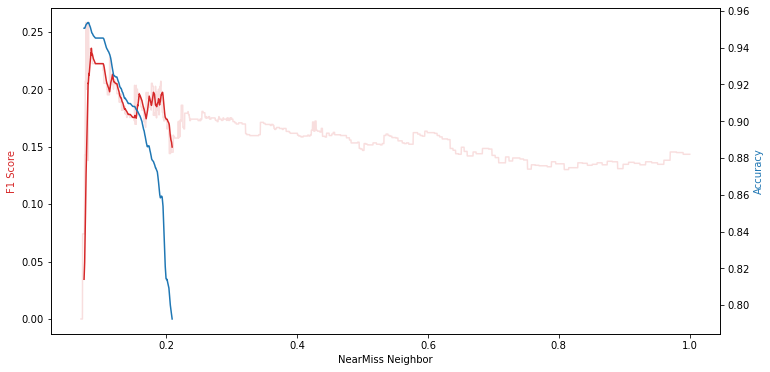

In [ ]:
## Plotting moving average of Best near miss model Neighbor and scores
for i in range(15,len(results)):
    results_sm['MA_F1'][i] = (results_sm['F1 Score'][i-15:i]).mean()
    results_sm['MA_Acc'][i] = (results_sm['Accuracy'][i-15:i]).mean()

## Plot
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(results_sm['Neighbor'], results_sm['MA_F1'], color='tab:red', label="F1 Score")
ax.plot(results_sm['Neighbor'], results_sm['F1 Score'], color='tab:red', label="F1 Score", alpha=0.15)
ax.set_ylabel('F1 Score', color='tab:red')
ax.set_xlabel("NearMiss Neighbor")
ax2=ax.twinx()
ax2.plot(results_sm['Neighbor'], results_sm['MA_Acc'], color='tab:blue', label="Accuracy")
ax2.set_ylabel('Accuracy', color='tab:blue')
plt.show()

In [ ]:
## Retrieve result with highest F1 Score
results_sm.loc[results_sm['F1 Score'].idxmax()]

Neighbor    0.077442
C                  9
Solver          saga
Accuracy    0.954990
F1 Score    0.258065
MA_Acc      0.952250
MA_F1       0.114395
Name: 24, dtype: object

In [ ]:
## Run best model on testing data
sm = NearMiss(version=1,sampling_strategy= 0.077442)
X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)
model = LogisticRegression(C=9, 
                           solver="newton-cg",
                    random_state=425).fit(X_train_res, Y_train_res)
#using the best model on the test data
Y_test_pred = model.predict(X_test)
#generating the model report
generate_model_report(Y_test, Y_test_pred)
#creating the confusion matrix 
conf_mat = confusion_matrix(Y_test, Y_test_pred)
pd.crosstab(Y_test, Y_test_pred, rownames=['Predicted'], colnames=['Actual'])

Accuracy:  0.9455968688845401
Precision: 0.2692307692307692
Recall:    0.05511811023622047
F1 Score:  0.0915032679738562
AUC Score: 0.5236463697803836


Actual,0.0,1.0
Predicted,,
0.0,2409,19
1.0,120,7
